### A notebook for 04-distillation experiment

In this notebook, we will show how to distill a quantized model from the baseline model in Homework 01 and 1a.

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import tensorflow.contrib as tf_contrib
from scipy import io as scio

### Configurations

In [2]:
minibatch_size = 128  # the number of instances in a batch
nr_channel = 3 # the channels of image
image_shape = (32, 32) # the image shape (height, width)
nr_class = 10 # the number of classes
nr_epoch = 60 # the max epoch of training
weight_decay = 1e-10 # a strength of regularization
test_interval = 5 # test in every ${test_interval} epochs
show_interval = 10 # print a message of training in every ${show_interval} minibatchs

In [3]:
class Dataset():
    dataset_path = '../../../dataset/SVHN'  # a path saves dataset
    dataset_meta = {
        'train': ([os.path.join(dataset_path, 'train_32x32.mat')], 73257),
        'test': ([os.path.join(dataset_path, 'test_32x32.mat')], 26032),
    }
    
    def __init__(self, dataset_name):
        self.files, self.instances = self.dataset_meta[dataset_name]
    
    def load(self):
        '''Load dataset metas from files'''
        datas_list, labels_list = [], []
        for f in self.files:
            samples = scio.loadmat(f)
            datas_list.append(samples['X'])
            labels_list.append(samples['y'])
        self.samples = {
            'X': np.concatenate(datas_list, axis=3), # datas
            'Y': np.concatenate(labels_list, axis=0), # labels
        }
        return self

    def instance_generator(self):
        '''a generator to yield a sample'''
        for i in range(self.instances):
            img = self.samples['X'][:, :, :, i]
            label = self.samples['Y'][i, :][0]
            if label == 10:
                label = 0
            img = cv2.resize(img, image_shape)
            yield img.astype(np.float32), np.array(label, dtype=np.int32)
    
    @property
    def instances_per_epoch(self):
        return 25600 # set for a fast experiment
        #return self.instances
    
    @property
    def minibatchs_per_epoch(self):
        return 200 # set for a fast experimetn
        #return self.instances // minibatch_size

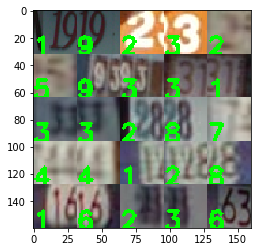

In [4]:
# show an img from dataset
%matplotlib inline
import matplotlib.pyplot as plt

ds = Dataset('train').load()
ds_gen = ds.instance_generator()

imggrid = []
for i in range(25):
    img, label = next(ds_gen) # yield a sample
    cv2.putText(img, str(label), (0, image_shape[0]), cv2.FONT_HERSHEY_SIMPLEX, 0.6, 
                (0, 255, 0), 2) # put a label on img
    imggrid.append(img) 

# make an img grid from an img list
imggrid = np.array(imggrid).reshape((5, 5, img.shape[0], img.shape[1], img.shape[2]))
imggrid = imggrid.transpose((0, 2, 1, 3, 4)).reshape((5*img.shape[0], 5*img.shape[1], 3)) 
imggrid = cv2.cvtColor(imggrid.astype('uint8'), cv2.COLOR_BGR2RGB)

# show
plt.figure()
plt.imshow(imggrid)
plt.show()

### Building the teacher model

In [5]:
class BigModel:
    def __init__(self, temperature):
        self.ckpt = tf.train.get_checkpoint_state('../../models') ### load teacher model here
        self.temperature = temperature
        self.weight_init = tf_contrib.layers.variance_scaling_initializer(factor=1.0,
                                mode='FAN_IN', uniform=False)
        self.bias_init = tf.zeros_initializer()
        self.reg = tf_contrib.layers.l2_regularizer(weight_decay)
        
        '''build computation graph of teacher model'''
        self.placeholder, self.label_onehot, self.logits = self.build()
        self.predict = tf.nn.softmax(self.logits/self.temperature)
        
        self.saver = tf.train.Saver()
        self.path = self.ckpt.model_checkpoint_path
    
    def _conv_layer(self, name, inp, kernel_shape, stride, padding='SAME',is_training=False):
        with tf.variable_scope(name) as scope:
            conv_filter = tf.get_variable(name='filter', shape=kernel_shape,
                                          initializer=self.weight_init, regularizer=self.reg)
            conv_bias = tf.get_variable(name='bias', shape=kernel_shape[-1],
                                        initializer=self.bias_init)
            x = tf.nn.conv2d(inp, conv_filter, strides=[1, stride, stride, 1],
                             padding=padding, data_format='NHWC')
            x = tf.nn.bias_add(x, conv_bias, data_format='NHWC')
            x = tf.layers.batch_normalization(x, axis=3, training=is_training)
            x = tf.nn.relu(x)
        return x

    def _pool_layer(self, name, inp, ksize, stride, padding='SAME', mode='MAX'):
        assert mode in ['MAX', 'AVG'], 'the mode of pool must be MAX or AVG'
        if mode == 'MAX':
            x = tf.nn.max_pool(inp, ksize=[1, ksize, ksize, 1], strides=[1, stride, stride, 1],
                               padding=padding, name=name, data_format='NHWC')
        elif mode == 'AVG':
            x = tf.nn.avg_pool(inp, ksize=[1, ksize, ksize, 1], strides=[1, stride, stride, 1],
                               padding=padding, name=name, data_format='NHWC')
        return x

    def _fc_layer(self, name, inp, units, dropout=0.5):
        with tf.variable_scope(name) as scope:
            shape = inp.get_shape().as_list()
            dim = 1
            for d in shape[1:]:
                dim *= d
            x = tf.reshape(inp, [-1, dim]) # flatten
            if dropout > 0:
                x = tf.nn.dropout(x, keep_prob=dropout, name='dropout')
            x = tf.layers.dense(x, units, kernel_initializer=self.weight_init,
                                bias_initializer=self.bias_init, kernel_regularizer=self.reg)
        return x


    def build(self):
        data = tf.placeholder(tf.float32, shape=(None,)+ image_shape+(nr_channel,),
                              name='data')
        label = tf.placeholder(tf.int32, shape=(None,), name='label')
        # convert the format of label to one-hot
        label_onehot = tf.one_hot(label, nr_class, dtype=tf.int32)
        # a setting for bn
        is_training = tf.placeholder(tf.bool, name='is_training')

        # conv1
        x = self._conv_layer(name='conv1', inp=data,
                             kernel_shape=[3, 3, nr_channel, 16], stride=1,
                             is_training=is_training) # Nx32x32x32
        x = self._pool_layer(name='pool1', inp=x, ksize=2, stride=2, mode='MAX') # Nx16x16x16

        # conv2
        x = self._conv_layer(name='conv21', inp=x, kernel_shape=[3, 3, 16, 32],
                             stride=1, is_training=is_training)
        x = self._conv_layer(name='conv22', inp=x, kernel_shape=[3, 3, 32, 32],
                             stride=1, is_training=is_training)
        x = self._pool_layer(name='pool2', inp=x, ksize=2, stride=2, mode='MAX') # Nx8x8x32

        # conv3
        x = self._conv_layer(name='conv31', inp=x, kernel_shape=[3, 3, 32, 64],
                             stride=1, is_training=is_training)
        x = self._conv_layer(name='conv32', inp=x, kernel_shape=[3, 3, 64, 64],
                             stride=1, is_training=is_training)
        x = self._pool_layer(name='pool3', inp=x, ksize=2, stride=2, mode='MAX') # Nx4x4x64

        # conv4
        x = self._conv_layer(name='conv41', inp=x, kernel_shape=[3, 3, 64, 128],
                             stride=1, is_training=is_training)
        x = self._conv_layer(name='conv42', inp=x, kernel_shape=[3, 3, 128, 128],
                             stride=1, is_training=is_training)
        x = self._pool_layer(name='pool4', inp=x, ksize=4, stride=4, mode='AVG') # Nx1x1x128
        # fc1
        logits = self._fc_layer(name='fc1', inp=x, units=nr_class, dropout=0)

        placeholders = {
            'data': data,
            'label': label,
            'is_training': is_training,
        }
        return placeholders, label_onehot, logits

    def start_session(self):
        self.sess = tf.Session()        

    def load_from_checkpoint(self):
        self.saver.restore(self.sess, self.path)
    
    def get_prediction(self, data): ### get label from teacher model
        return self.sess.run(self.predict, feed_dict = {self.placeholder['data']:data, self.placeholder['is_training']: False})
   
    def close_session(self):
        self.sess.close()


### quantization method

In [6]:
def round_bit(x, num_bit): ### take input ranging from [0,1] 
    max_val = 2 ** num_bit - 1
    y = x + tf.stop_gradient((tf.floor(x * max_val + 0.5)) / max_val-x)
    return y


def quantize_w(x, num_bit):
    scale = tf.reduce_mean(tf.abs(x)) * 2
    y = x+ tf.stop_gradient((round_bit(tf.clip_by_value(x / scale, -0.5, 0.5) + 0.5, num_bit=num_bit) - 0.5) * scale - x)
    return y


def proc(x, multiplier, num_bit):
    x = tf.clip_by_value(x * multiplier, 0, 1)
    x = round_bit(x, num_bit=num_bit)
    return x

'''define quantized convolution '''
def conv2d_quantize(name, inp, stride, padding, data_format, kernel_shape, conv_filter, conv_bias, f_num_bits = None, w_num_bits = None, if_num_bits=None, is_training=False):
    if if_num_bits is None:
        if_num_bits = f_num_bits

    if w_num_bits != 0:
        quantize_conv_filter = quantize_w(tf.tanh(conv_filter), w_num_bits) ### quantize model weights

    _, _, _, oc = quantize_conv_filter.get_shape().as_list()
    conv = tf.nn.conv2d(inp, quantize_conv_filter, strides = [1, stride, stride, 1], padding=padding, data_format='NHWC')
    bias = tf.nn.bias_add(conv, conv_bias, data_format ='NHWC')
    bn = tf.layers.batch_normalization(bias, axis=3, training=is_training, center = False, scale = False)
    affine_k = tf.get_variable(name = name+'affine_k', initializer=np.array(np.ones((1, 1, 1, oc)), dtype=np.float32))

    affine_b = tf.get_variable(name = name+'affine_b', initializer=np.array(np.zeros((1, 1, 1, oc)), dtype=np.float32))
   
    affine = (tf.abs(affine_k) + 1.0) * bn + affine_b
    if f_num_bits != 0:
        out = proc(affine, 0.1, f_num_bits) ### quantize feature
   
    return out


### Building quantized model

In [7]:
class Model():
    def __init__(self):
        # set the initializer of conv_weight and conv_bias
        self.weight_init = tf_contrib.layers.variance_scaling_initializer(factor=1.0,
                                mode='FAN_IN', uniform=False)
        self.bias_init = tf.zeros_initializer()
        self.reg = tf_contrib.layers.l2_regularizer(weight_decay)

    def _conv_layer(self, name, inp, kernel_shape, stride, padding='SAME', f_num_bits=None,w_num_bits = None, if_num_bits = None, is_training=False):
        with tf.variable_scope(name) as scope:

            conv_filter = tf.get_variable(name=name+'_filter', shape=kernel_shape, initializer=self.weight_init, regularizer=self.reg)

            conv_bias = tf.get_variable(name=name+'_bias', shape=kernel_shape[-1], initializer=self.bias_init)
            '''use quantized convolution here'''
            x = conv2d_quantize(name + '_quantize', inp, stride, padding, data_format='NHWC',kernel_shape = kernel_shape, conv_filter = conv_filter, conv_bias = conv_bias, f_num_bits = f_num_bits, w_num_bits = w_num_bits, if_num_bits = if_num_bits, is_training = is_training )
        return x

    def _pool_layer(self, name, inp, ksize, stride, padding='SAME', mode='MAX'):
        assert mode in ['MAX', 'AVG'], 'the mode of pool must be MAX or AVG'
        if mode == 'MAX':
            x = tf.nn.max_pool(inp, ksize=[1, ksize, ksize, 1], strides=[1, stride, stride, 1],
                               padding=padding, name=name, data_format='NHWC')
        elif mode == 'AVG':
            x = tf.nn.avg_pool(inp, ksize=[1, ksize, ksize, 1], strides=[1, stride, stride, 1],
                               padding=padding, name=name, data_format='NHWC')
        return x

    def _fc_layer(self, name, inp, units, dropout=0.5):
        with tf.variable_scope(name) as scope:
            shape = inp.get_shape().as_list()
            dim = 1
            for d in shape[1:]:
                dim *= d
            x = tf.reshape(inp, [-1, dim]) # flatten
            if dropout > 0:
                x = tf.nn.dropout(x, keep_prob=dropout, name='dropout')
            x = tf.layers.dense(x, units, kernel_initializer=self.weight_init,
                                bias_initializer=self.bias_init, kernel_regularizer=self.reg)
        return x

    #def _softmax_layer(self, name, inp):
    #    x = tf.nn.softmax(inp, name=name)
    #    return x

    def build(self):
        w_bits = 2
        f_bits = 1
        data = tf.placeholder(tf.float32, shape=(None,)+ image_shape+(nr_channel,),
                              name='data')
        label = tf.placeholder(tf.int32, shape=(None,), name='label')
        # convert the format of label to one-hot
        label_onehot = tf.one_hot(label, nr_class, dtype=tf.int32)
        # a setting for bn
        is_training = tf.placeholder(tf.bool, name='is_training')

        # conv1
        x = self._conv_layer(name='quantized_conv1', inp=data,
                             kernel_shape=[3, 3, nr_channel, 16], stride=1, f_num_bits = f_bits, w_num_bits = w_bits, is_training=is_training) # Nx32x32x32
        x = self._pool_layer(name='quantized_pool1', inp=x, ksize=2, stride=2, mode='MAX') # Nx16x16x16

        # conv2
        x = self._conv_layer(name='quantized_conv21', inp=x, kernel_shape=[3, 3, 16, 32],
                             stride=1, f_num_bits = f_bits, w_num_bits = w_bits,is_training=is_training)
        x = self._conv_layer(name='quantized_conv22', inp=x, kernel_shape=[3, 3, 32, 32],
                             stride=1, f_num_bits = f_bits, w_num_bits = w_bits, is_training=is_training)
        x = self._pool_layer(name='quantized_pool2', inp=x, ksize=2, stride=2, mode='MAX') # Nx8x8x32

        # conv3
        x = self._conv_layer(name='quantized_conv31', inp=x, kernel_shape=[3, 3, 32, 64],
                             stride=1, f_num_bits = f_bits, w_num_bits = w_bits,is_training=is_training)
        x = self._conv_layer(name='quantized_conv32', inp=x, kernel_shape=[3, 3, 64, 64],
                             stride=1, f_num_bits = f_bits, w_num_bits = w_bits,is_training=is_training)
        x = self._pool_layer(name='quantized_pool3', inp=x, ksize=2, stride=2, mode='MAX') # Nx4x4x64

        # conv4
        
        x = self._conv_layer(name='quantized_conv41', inp=x, kernel_shape=[3, 3, 64, 128],
                             stride=1, f_num_bits = f_bits, w_num_bits = w_bits,is_training=is_training)
        x = self._conv_layer(name='quantized_conv42', inp=x, kernel_shape=[3, 3, 128, 128],
                             stride=1, f_num_bits = f_bits, w_num_bits = w_bits,is_training=is_training)
        x = self._pool_layer(name='quantized_pool4', inp=x, ksize=4, stride=4, mode='AVG') # Nx1x1x128
        
        # fc1
        logits = self._fc_layer(name='quantized_fc1', inp=x, units=nr_class, dropout=0)

        placeholders = {
            'data': data,
            'label': label,
            'is_training': is_training,
        }
        return placeholders, label_onehot, logits




In [8]:
def get_dataset_batch(ds_name):
    dataset = Dataset(ds_name)
    ds_gnr = dataset.load().instance_generator
    ds = tf.data.Dataset().from_generator(ds_gnr, output_types=(tf.float32, tf.int32),)
    if ds_name == 'train':
        ds = ds.shuffle(dataset.instances_per_epoch)
        ds = ds.repeat(nr_epoch)
    elif ds_name == 'test':
        ds = ds.repeat(nr_epoch // test_interval)
    ds = ds.batch(minibatch_size)
    ds_iter = ds.make_one_shot_iterator()
    sample_gnr = ds_iter.get_next()
    return sample_gnr, dataset

###  Training

In [9]:
def distill(temperature, teacher_network):


    g1 = tf.Graph()

    with g1.as_default():
        train_batch_gnr, train_set = get_dataset_batch(ds_name='train')
        test_batch_gnr, test_set = get_dataset_batch(ds_name='test')

        ### build computation graph for quantized model
        network = Model()
        placeholders, label_onehot, logits = network.build()
        preds = tf.nn.softmax(logits)
        ### set target label
        target_label_onehot = tf.placeholder(tf.float32, shape=(None,) + (nr_class,), name='target_label')
        ### set performance metric
        correct_pred = tf.equal(tf.cast(tf.argmax(preds, 1), dtype=tf.int32),
                            tf.cast(tf.argmax(label_onehot, 1), dtype=tf.int32))
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
        ### set loss
        loss_reg = tf.add_n(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))
        
        loss = tf.losses.softmax_cross_entropy(target_label_onehot, logits/temperature)  + loss_reg

        global_steps = tf.Variable(0, trainable=False)
        boundaries = [train_set.minibatchs_per_epoch*15, train_set.minibatchs_per_epoch*40]
        values = [0.01, 0.001, 0.0005]
        lr = tf.train.piecewise_constant(global_steps, boundaries, values)
        opt = tf.train.AdamOptimizer(lr)
        
        ### only apply optimization on quantized models
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='quantize')
        trainable_varlist = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='quantize')
        with tf.control_dependencies(update_ops):
            train = opt.minimize(loss, var_list= trainable_varlist)
        
        
    tf.set_random_seed(12345) # ensure consistent results
    global_cnt = 0
    epoch_start = 0

    with tf.Session(graph=g1) as sess:
        sess.run(tf.global_variables_initializer()) # init all variables
        
        ## training
        for epoch in range(epoch_start+1, nr_epoch+1):
            for _ in range(train_set.minibatchs_per_epoch):
                global_cnt += 1
                images, labels = sess.run(train_batch_gnr)
                target_labels = teacher_network.get_prediction(images) ### get teacher label
                feed_dict = {
                    placeholders['data']: images,
                    placeholders['label']: labels,
                    target_label_onehot: target_labels,
                    global_steps: global_cnt,
                    placeholders['is_training']: True,
                }
                _, loss_v, loss_reg_v, acc_v, lr_v = sess.run([train, loss, loss_reg,
                                                                        accuracy, lr],
                                                                       feed_dict=feed_dict)
                if global_cnt % show_interval == 0:
                    print(
                        "e:{},{}/{}".format(epoch, global_cnt % train_set.minibatchs_per_epoch,
                                            train_set.minibatchs_per_epoch),
                        'loss: {:.3f}'.format(loss_v),
                        'loss_reg: {:.3f}'.format(loss_reg_v),
                        'acc: {:.3f}'.format(acc_v),
                        'lr: {:.3f}'.format(lr_v),
                    )

            ## validation
            if epoch % test_interval == 0:
                loss_sum = 0
                acc_sum = 0
                for i in range(test_set.minibatchs_per_epoch):
                    images, labels = sess.run(test_batch_gnr)
                    target_labels = sess.run(label_onehot, feed_dict = {placeholders['label']:labels})
                    feed_dict = {
                        placeholders['data']: images,
                        placeholders['label']: labels,
                        target_label_onehot: target_labels,
                        global_steps: global_cnt,
                        placeholders['is_training']: False
                    }
                    loss_v, acc_v = sess.run([loss, accuracy],
                                                      feed_dict=feed_dict)
                    loss_sum += loss_v
                    acc_sum += acc_v
                
                print("\n**************Validation results****************")
                print('loss_avg: {:.3f}'.format(loss_sum/test_set.minibatchs_per_epoch),
                      'accuracy_avg: {:.3f}'.format(acc_sum/test_set.minibatchs_per_epoch))
                print("************************************************\n")

    

        print('Training is done, exit.')


In [10]:
temperature = 1  ### set temperature 
teacher_network = BigModel(temperature) ### Build teacher model
teacher_network.start_session() 
teacher_network.load_from_checkpoint()
distill(temperature, teacher_network) 

INFO:tensorflow:Restoring parameters from ../../models/epoch-60-17160
e:1,10/200 loss: 2.264 loss_reg: 0.000 acc: 0.148 lr: 0.010
e:1,20/200 loss: 2.232 loss_reg: 0.000 acc: 0.203 lr: 0.010
e:1,30/200 loss: 2.181 loss_reg: 0.000 acc: 0.250 lr: 0.010
e:1,40/200 loss: 2.297 loss_reg: 0.000 acc: 0.180 lr: 0.010
e:1,50/200 loss: 2.269 loss_reg: 0.000 acc: 0.180 lr: 0.010
e:1,60/200 loss: 2.232 loss_reg: 0.000 acc: 0.188 lr: 0.010
e:1,70/200 loss: 2.237 loss_reg: 0.000 acc: 0.219 lr: 0.010
e:1,80/200 loss: 2.251 loss_reg: 0.000 acc: 0.156 lr: 0.010
e:1,90/200 loss: 2.201 loss_reg: 0.000 acc: 0.227 lr: 0.010
e:1,100/200 loss: 2.293 loss_reg: 0.000 acc: 0.141 lr: 0.010
e:1,110/200 loss: 2.221 loss_reg: 0.000 acc: 0.203 lr: 0.010
e:1,120/200 loss: 2.178 loss_reg: 0.000 acc: 0.195 lr: 0.010
e:1,130/200 loss: 2.227 loss_reg: 0.000 acc: 0.156 lr: 0.010
e:1,140/200 loss: 2.194 loss_reg: 0.000 acc: 0.211 lr: 0.010
e:1,150/200 loss: 2.228 loss_reg: 0.000 acc: 0.242 lr: 0.010
e:1,160/200 loss: 2.235 

KeyboardInterrupt: 